# Live cu-inj-live-impact 

In [1]:
# Setup directories, and convert dashboard notebook to a script for importing
!./setup.bash

[NbConvertApp] Converting notebook make_dashboard.ipynb to script
[NbConvertApp] Writing 5417 bytes to make_dashboard.py
[NbConvertApp] Converting notebook get_vcc_image.ipynb to script
[NbConvertApp] Writing 2507 bytes to get_vcc_image.py


In [2]:
from impact import evaluate_impact_with_distgen, run_impact_with_distgen
from impact.tools import isotime
from impact.evaluate import  default_impact_merit
from impact import Impact

from make_dashboard import make_dashboard
from get_vcc_image import get_live_distgen_xy_dist

import matplotlib as mpl

In [3]:
import pandas as pd

import json
import epics

import sys
import os
from time import sleep, time


import matplotlib.pyplot as plt

import matplotlib as mpl
#mpl.use('Agg')

# Nicer plotting
# %config InlineBackend.figure_format = 'retina'

# Logging

In [4]:
PREFIX = 'lume-impact-live-demo'

In [5]:
import logging

# Gets or creates a logger
logger = logging.getLogger(PREFIX)  

# set log level
logger.setLevel(logging.INFO)

# define file handler and set formatter
file_handler = logging.FileHandler(f'{PREFIX}.log')
#formatter    = logging.Formatter('%(asctime)s : %(levelname)s : %(name)s : %(message)s')
formatter    = logging.Formatter(fmt="%(asctime)s :  %(name)s : %(message)s ", datefmt="%Y-%m-%dT%H:%M:%S%z")

# Add print to stdout
logger.addHandler(logging.StreamHandler(sys.stdout))

file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

# Configuration

Set up basic input sources and output path.

Depends on the `$LCLS_LATTICE` environmental variable pointing to a checked out copy of https://github.com/slaclab/lcls-lattice (protected)

In [6]:
ROOT = os.getcwd()

In [7]:
# Directory for summary output
OUTPUTDIR = os.path.join(ROOT, 'output')

# Directory to output plots
PLOTDIR = os.path.join(ROOT, 'plot')

# Directory for archive files
APATH = os.path.join(ROOT, 'archive')

# PV -> Sim conversion table
CSV =  'pv_mapping/cu_inj_impact.csv'

# Base input files
CONFIG0 = {'impact_config': os.path.expandvars('$LCLS_LATTICE/impact/models/cu_inj/ImpactT.yaml'),
          'distgen_input_file': os.path.expandvars('$LCLS_LATTICE/distgen/models/cu_inj/vcc_image/distgen.yaml')
         }

# Dummy file for distgen
DISTGEN_LASER_FILE = os.path.join(ROOT, 'distgen_laser.txt')

# Base settings
SETTINGS0 = {
 'distgen:t_dist:length:value': 4 * 1.65 ,     #  Inferred pulse stacker FWHM: 4 ps, converted to tukey length
 'distgen:n_particle': 100000,   
 'stop': 16.5, 
 'timeout': 100000,
 'header:Nx': 32,
 'header:Ny': 32,
 'header:Nz': 32,
 #'total_charge':0, # Set to 0 to turn off Space Charge for faster execution 
 'change_timestep_1:dt':4e-12, 
 
 # Parallel control
 'header:Nprow':4,
 'header:Npcol':8,
 'use_mpi':True,
 'mpi_run': 'mpirun -n {n} --use-hwthread-cpus {command_mpi}'
   }

# EPICS -> Simulation settings

In [8]:
IRIS_DIAMETER_FROM_ENUM_IN_MM = {0:'LCLS', # LCLS cutout picture
       1 :1.8 ,
       2 :1.6 ,
       3 :1.4 ,
       4 :1.2 ,
       5 :1.1 ,
       6 :1.0 ,
       7 :0.8 ,
       8 :0.6 ,
       9 :0.5 ,
       10: 0.4 , 
       11: 0.3 }

def get_live_settings(csv, base_settings={}):
    """
    Fetches live settings for all devices in the CSV table, and translates them to simulation inputs
     
    """
    df = pd.read_csv(csv)
    pv_names = list(df['device_pv_name'])
    
    df['pv_value'] = epics.caget_many(pv_names)
    df.set_index('device_pv_name', inplace=True)
    
    # Custom for enum
    iris_enum = int(df.at['IRIS:LR20:130:CONFG_SEL', 'pv_value'])
    df.at['IRIS:LR20:130:CONFG_SEL', 'pv_value'] = IRIS_DIAMETER_FROM_ENUM_IN_MM[iris_enum]
    
    # Assign impact
    df['impact_value'] = df['impact_factor']*df['pv_value'] 

    # Collect settings
    settings = base_settings.copy()
    settings.update(dict(zip(df['impact_name'], df['impact_value'])))

    # VCC image
    settings['distgen:xy_dist:file'] = get_live_distgen_xy_dist(filename=DISTGEN_LASER_FILE)
    # We won't need this anymore
    settings.pop('distgen:r_dist:sigma_xy:value')
    
    
    return settings, df

LIVE_SETTINGS, DF = get_live_settings(CSV, SETTINGS0)
DF[['Variable', 'bmad_name', 'pv_value','pv_unit',  'device_min', 'device_max',  'impact_name', 'impact_factor', 'impact_unit',
       'impact_description',  'impact_value']]

,Variable,bmad_name,pv_value,pv_unit,device_min,device_max,impact_name,impact_factor,impact_unit,impact_description,impact_value
device_pv_name,,,,,,,,,,,
IRIS:LR20:130:CONFG_SEL,Iris diameter ENUM,NaN,1.200000,mm,0.300,1.800,distgen:r_dist:sigma_xy:value,0.333333,mm,Gaussian is cut off at 1.5 sigma_xu,4.000000e-01
SOLN:IN20:121:BDES,Solenoid,SOL1,0.466720,kG*m,0.000,0.550,SOL1:solenoid_field_scale,0.514272,T,peak field,2.400211e-01
QUAD:IN20:121:BDES,Corrector quad,CQ01,0.008450,kG,-0.015,0.015,CQ01:b1_gradient,-0.476190,T/m,Corrector quad gradient,-4.023810e-03
QUAD:IN20:122:BDES,Skew quad,SQ01,0.003120,kG,-0.015,0.015,SQ01:b1_gradient,-0.476190,T/m,Skew quad gradient,-1.485693e-03
ACCL:IN20:300:L0A_PDES,L0A phase,L0A,0.000000,deg,-20.000,0.000,L0A_phase:dtheta0_deg,1.000000,deg,Phase relative to on-crest,0.000000e+00
ACCL:IN20:400:L0B_PDES,L0B phase,L0B,-2.500000,deg,-20.000,0.000,L0B_phase:dtheta0_deg,1.000000,deg,Phase relative to on-crest,-2.500000e+00
ACCL:IN20:300:L0A_ADES,L0B voltage,L0A,58.000000,MV,0.000,110.000,L0A_scale:voltage,1000000.000000,V,Voltage,5.800000e+07
ACCL:IN20:400:L0B_ADES,L0B voltage,L0B,70.824584,MV,0.000,110.000,L0B_scale:voltage,1000000.000000,V,Voltage,7.082458e+07
QUAD:IN20:361:BDES,QA01,QA01,-3.353360,kG,-20.000,20.000,QA01:b1_gradient,-0.925926,T/m,10.8 cm quad,3.104963e+00


In [9]:
#%%time
#I0 = run_impact_with_distgen(LIVE_SETTINGS, **CONFIG0, verbose=True )
    

In [10]:
#I0.plot(['sigma_x', 'sigma_y'], y2=['sigma_x'], ylim2=(0,2e-3), figsize=(16,9))

In [11]:
#I0.initial_particles.plot('x', 'y')

# Get live values, run Impact-T, make dashboard

In [12]:
# Patch this into the function below for the dashboard creation
def my_merit(impact_object, itime):
    # Collect standard output statistics
    merit0 = default_impact_merit(impact_object)
    # Make the dashboard from the evaluated object
    plot_file = make_dashboard(impact_object, itime=itime, outpath=PLOTDIR)
    #print('Dashboard written:', plot_file)
    logger.info(f'Dashboard written: {plot_file}')
    
    # Assign extra info
    merit0['plot_file'] = plot_file    
    merit0['isotime'] = itime
    
    # Clear any buffers
    plt.close('all')

    return merit0

In [13]:
def run1():
    dat = {}
    
    # Acquire settings
    mysettings, df = get_live_settings(CSV, SETTINGS0)
    itime = isotime()
    dat['isotime'] = itime
    
    # Record inputs
    dat['inputs'] = mysettings
    dat['config'] = CONFIG0
    dat['pv_mapping_dataframe'] = df.to_dict()
    
    
    logger.info(f'Acquired settings from EPICS at: {itime}')
    logger.info(f'Running evaluate_impact_with_distgen...')
    
    t0 = time()
    dat['outputs'] = evaluate_impact_with_distgen(mysettings,
                                       merit_f=lambda x: my_merit(x, itime),
                                       archive_path=APATH,
                                       **CONFIG0 )
    logger.info(f'...finished in {(time()-t0)/60:.1f} min')
    fname = fname=f'{OUTPUTDIR}/{PREFIX}-{itime}.json'
    json.dump(dat, open(fname, 'w'))
    #print('Written:', fname)
    logger.info(f'Output written: {fname}')
    return dat
    

In [14]:
# Here are the results
result = run1()
result.keys()

Acquired settings from EPICS at: 2021-03-04T17:54:28-08:00
Running evaluate_impact_with_distgen...
Dashboard written: /nfs/slac/g/beamphysics/cmayes/GitHub/lume-impact-live-demo/plot/lume-impact-live-demo-2021-03-04T17:54:28-08:00-dashboard.png
...finished in 5.3 min
Output written: /nfs/slac/g/beamphysics/cmayes/GitHub/lume-impact-live-demo/output/lume-impact-live-demo-2021-03-04T17:54:28-08:00.json


dict_keys(['isotime', 'inputs', 'config', 'pv_mapping_dataframe', 'outputs'])

In [15]:
# Basic config
result['config']

{'impact_config': '/u/ad/cmayes/nfs/GitHub/lcls-lattice/impact/models/cu_inj/ImpactT.yaml',
 'distgen_input_file': '/u/ad/cmayes/nfs/GitHub/lcls-lattice/distgen/models/cu_inj/vcc_image/distgen.yaml'}

In [16]:
# Simulation inputs
result['inputs']

{'distgen:t_dist:length:value': 6.6,
 'distgen:n_particle': 100000,
 'stop': 16.5,
 'timeout': 100000,
 'header:Nx': 32,
 'header:Ny': 32,
 'header:Nz': 32,
 'change_timestep_1:dt': 4e-12,
 'header:Nprow': 4,
 'header:Npcol': 8,
 'use_mpi': True,
 'mpi_run': 'mpirun -n {n} --use-hwthread-cpus {command_mpi}',
 'SOL1:solenoid_field_scale': 0.24002112100791598,
 'CQ01:b1_gradient': -0.004023809522199999,
 'SQ01:b1_gradient': -0.0014856934755961987,
 'L0A_phase:dtheta0_deg': 0.0,
 'L0B_phase:dtheta0_deg': -2.5,
 'L0A_scale:voltage': 58000000.0,
 'L0B_scale:voltage': 70824584.05054374,
 'QA01:b1_gradient': 3.10496296321136,
 'QA02:b1_gradient': -2.435618518713368,
 'QE01:b1_gradient': 2.1739610186924354,
 'QE02:b1_gradient': -0.37194148151123685,
 'QE03:b1_gradient': -2.972181944682219,
 'QE04:b1_gradient': 2.729705277996154,
 'distgen:xy_dist:file': '/nfs/slac/g/beamphysics/cmayes/GitHub/lume-impact-live-demo/distgen_laser.txt'}

In [17]:
# Simulation outputs
result['outputs']

{'error': False,
 'end_t': 5.5068743e-08,
 'end_mean_z': 16.496552,
 'end_sigma_z': 0.00054746664,
 'end_norm_emit_z': 0.00011155141,
 'end_loadbalance_min_n_particle': 178.0,
 'end_loadbalance_max_n_particle': 10215.0,
 'end_n_particle': 100000.0,
 'end_moment3_x': 0.00020448741,
 'end_moment3_y': 6.6988891e-05,
 'end_moment3_z': 0.00060946145,
 'end_max_amplitude_x': 0.00081609375,
 'end_max_amplitude_y': 0.0020840614,
 'end_max_amplitude_z': 0.0012485494,
 'end_mean_x': -1.1515755e-06,
 'end_sigma_x': 0.00030663206,
 'end_norm_emit_x': 1.1164398e-06,
 'end_mean_y': 7.5350217e-07,
 'end_sigma_y': 0.00024216185,
 'end_norm_emit_y': 1.0520789e-06,
 'end_mean_gamma': 402.20102,
 'end_mean_beta': 0.99999691,
 'end_max_r': 0.0020840629,
 'end_sigma_gamma': 0.20492983,
 'end_moment4_x': 0.00037935568,
 'end_moment4_y': 0.00040832181,
 'end_moment4_z': 0.00065752035,
 'end_mean_pz': 205523665.27023098,
 'end_sigma_pz': 104719.24477302749,
 'end_cov_z__pz': 6.1204480217111,
 'end_moment3_px'

# Show the plot 

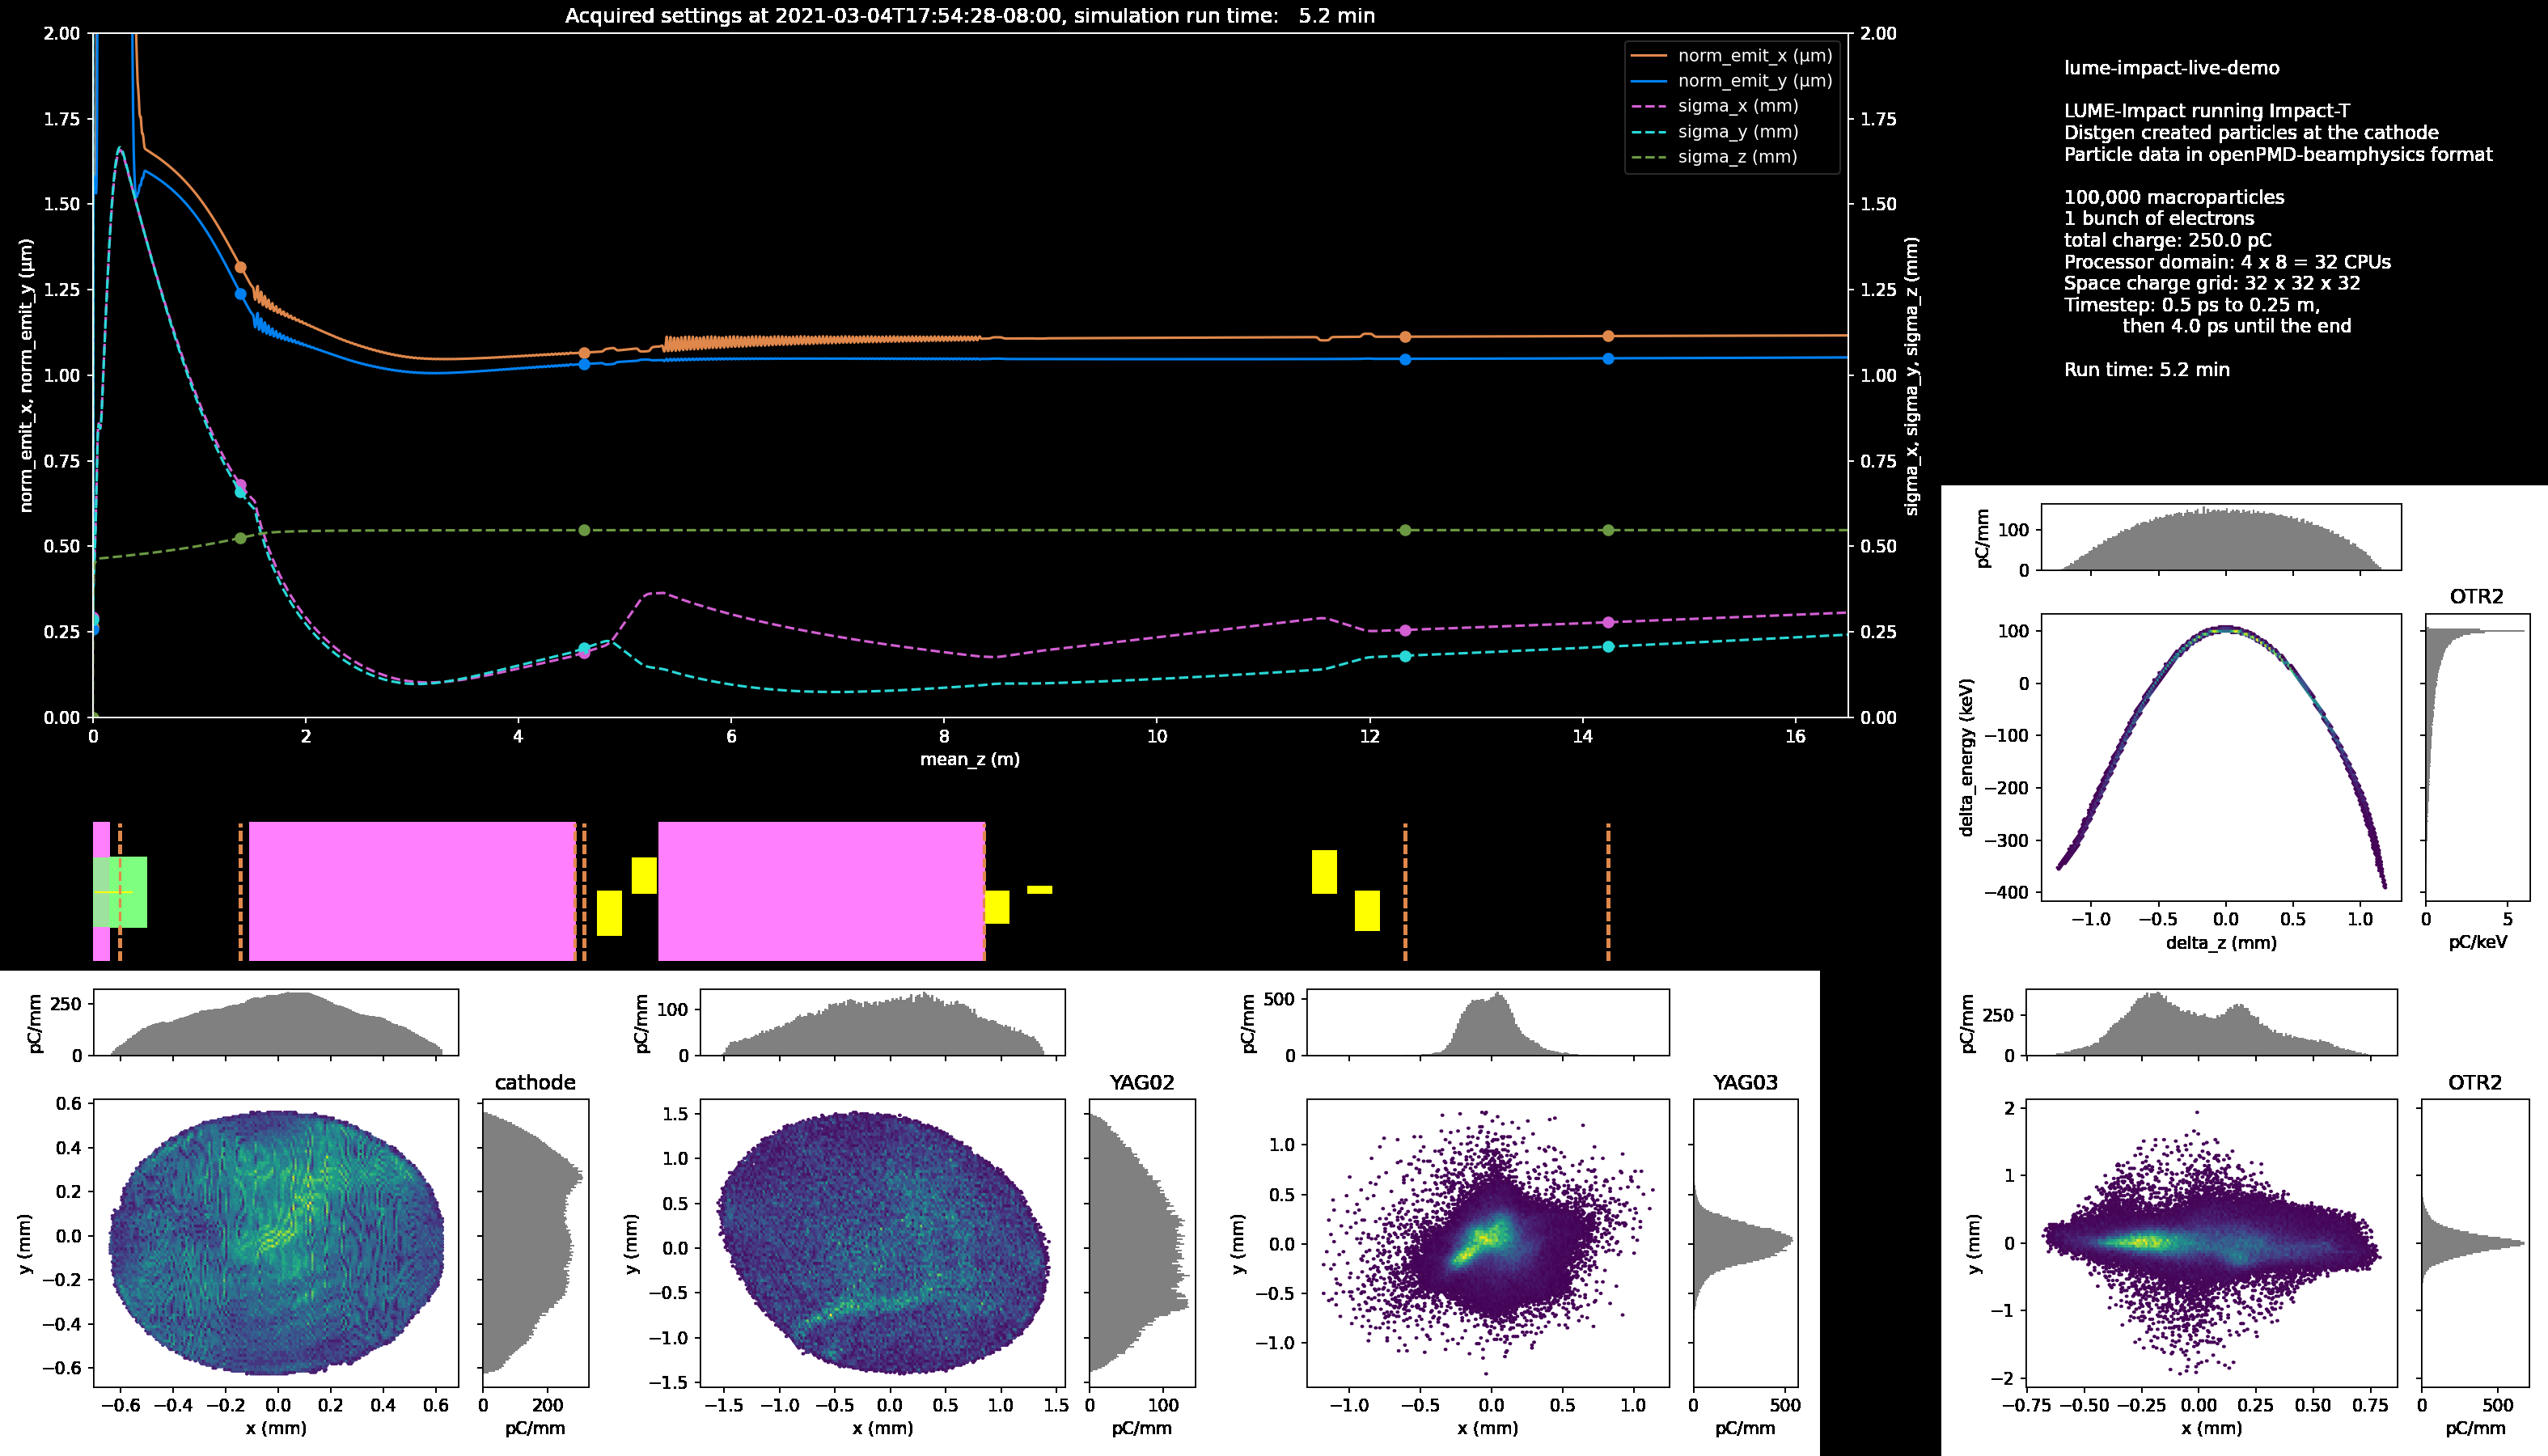

In [18]:
from IPython.display import Image
Image(filename=result['outputs']['plot_file']) 

# loop it


In [ ]:
while True:
    run1()